# Face Mask Detection with YOLOv8
This project detects face masks using YOLOv8 Object Detection.

## Steps:
1. Dataset Preparation (XML to YOLO Format Conversion).
2. Installing YOLOv8 (Ultralytics).
3. Train the YOLOv8 model.
4. Evaluate model performance.
5. Save Trained Model.
6. Run custom predictions on test images.


# 📦 Step 1: Dataset Preparation (XML to YOLO Format Conversion)

This step prepares the dataset for YOLOv8 object detection training.

- Upload your ZIP dataset (`face_mask.zip`) containing images and Pascal VOC XML annotations.
- The notebook will automatically:
  1. Extract the ZIP file.
  2. Convert Pascal VOC (XML) annotations into YOLO format.
  3. Organize images and labels in the correct folder structure required by YOLOv8:
     - `/datasets/images/train/`
     - `/datasets/labels/train/`
  4. Auto-generate `data.yaml` file (dataset config for YOLO).

## ✅ Class Labels Used:
- `0`: with_mask  
- `1`: without_mask  
- `2`: mask_weared_incorrect

After running this cell, your dataset will be fully ready for YOLOv8 training.


In [1]:
# ✅ YOLOv8 Dataset Converter (Colab Ready)

# Step 1: Upload ZIP Dataset
from google.colab import files
uploaded = files.upload()

# Step 2: Extract ZIP Dataset
import zipfile
import os

zip_path = next(iter(uploaded.keys()))
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/face_mask')

print("Dataset extracted.")

# Step 3: Convert XML Annotations to YOLO Format
import xml.etree.ElementTree as ET

# Paths
image_dir = '/content/face_mask/images'
annotation_dir = '/content/face_mask/annotations'

output_image_dir = '/content/datasets/images/train'
output_label_dir = '/content/datasets/labels/train'

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# Class Mapping
class_mapping = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}

for filename in os.listdir(annotation_dir):
    if filename.endswith('.xml'):
        xml_path = os.path.join(annotation_dir, filename)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        image_filename = root.find('filename').text
        img_path = os.path.join(image_dir, image_filename)

        # Copy image
        if os.path.exists(img_path):
            os.system(f'cp "{img_path}" "{output_image_dir}/{image_filename}"')
        else:
            print(f"Image missing: {image_filename}")
            continue

        # Convert annotation
        size = root.find('size')
        img_w = int(size.find('width').text)
        img_h = int(size.find('height').text)

        txt_filename = filename.replace('.xml', '.txt')
        txt_path = os.path.join(output_label_dir, txt_filename)

        with open(txt_path, 'w') as f:
            for obj in root.findall('object'):
                cls = obj.find('name').text
                if cls not in class_mapping:
                    continue
                cls_id = class_mapping[cls]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # YOLO format
                x_center = ((xmin + xmax) / 2) / img_w
                y_center = ((ymin + ymax) / 2) / img_h
                width = (xmax - xmin) / img_w
                height = (ymax - ymin) / img_h

                f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")

print("✅ XML Annotations Converted to YOLO Format.")

# Step 4: Create Dataset Config YAML for YOLOv8
yaml_content = f"""
path: /content/datasets
train: images/train
val: images/train  # (using same for now)
nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']
"""
with open('/content/datasets/data.yaml', 'w') as f:
    f.write(yaml_content.strip())

print("✅ Dataset Ready for YOLOv8 Training.")


Saving face_mask.zip to face_mask.zip
Dataset extracted.
✅ XML Annotations Converted to YOLO Format.
✅ Dataset Ready for YOLOv8 Training.


# Step 2: Installing YOLOv8 (Ultralytics)

In [2]:
# Install YOLOv8 (Ultralytics)
!pip install ultralytics --quiet

# ✅ Import YOLO
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

# 🚀 Step 3: Train YOLOv8 Model on Face Mask Dataset

We will now train the YOLOv8 object detection model on our face mask dataset.

- Model will detect multiple faces in an image and classify them as:
  - with_mask (0)
  - without_mask (1)
  - mask_weared_incorrect (2)

We are using YOLOv8’s built-in training pipeline.


In [4]:
# ✅ Load YOLOv8 Model (Nano Version — Fastest for Colab)
model = YOLO('yolov8n.pt')  # You can try 'yolov8s.pt' for better accuracy later

# ✅ Train Model
results = model.train(
    data='/content/datasets/data.yaml',
    epochs=10,
    imgsz=640,
    batch=16
)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

train: Scanning /content/datasets/labels/train.cache... 853 images, 0 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1239.3±676.0 MB/s, size: 388.4 KB)



val: Scanning /content/datasets/labels/train.cache... 853 images, 0 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.658      2.665      1.368         30        640: 100%|██████████| 54/54 [12:20<00:00, 13.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:41<00:00,  8.22s/it]

                   all        853       4072     0.0115      0.554      0.196      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.347      1.494      1.104         26        640: 100%|██████████| 54/54 [12:05<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:43<00:00,  8.28s/it]


                   all        853       4072      0.431      0.322       0.34      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.267      1.273      1.085         12        640: 100%|██████████| 54/54 [12:14<00:00, 13.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:45<00:00,  8.35s/it]

                   all        853       4072      0.613      0.531      0.561       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.237      1.168      1.068         52        640: 100%|██████████| 54/54 [12:24<00:00, 13.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:42<00:00,  8.22s/it]

                   all        853       4072      0.695      0.562        0.6      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G        1.2      1.052      1.048         13        640: 100%|██████████| 54/54 [12:37<00:00, 14.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:47<00:00,  8.43s/it]

                   all        853       4072      0.742      0.622      0.672      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.167     0.9548      1.038         18        640: 100%|██████████| 54/54 [12:33<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:43<00:00,  8.26s/it]


                   all        853       4072      0.811      0.654      0.727      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.144      0.896      1.026         10        640: 100%|██████████| 54/54 [12:10<00:00, 13.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:54<00:00,  8.68s/it]

                   all        853       4072      0.805      0.668      0.745      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.108     0.8339          1         27        640: 100%|██████████| 54/54 [12:35<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:37<00:00,  8.05s/it]

                   all        853       4072       0.88       0.71      0.796      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G        1.1       0.78     0.9961         19        640: 100%|██████████| 54/54 [12:22<00:00, 13.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:44<00:00,  8.33s/it]

                   all        853       4072      0.867      0.717      0.801      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.071     0.7489     0.9836         25        640: 100%|██████████| 54/54 [12:10<00:00, 13.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:38<00:00,  8.11s/it]

                   all        853       4072      0.842      0.767      0.834      0.582



10 epochs completed in 2.683 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [03:03<00:00,  6.79s/it]


                   all        853       4072      0.842      0.767      0.834      0.582
             with_mask        768       3232      0.898      0.929      0.955      0.681
          without_mask        286        717      0.779      0.819       0.86      0.571
 mask_weared_incorrect         97        123       0.85      0.554      0.687      0.493
Speed: 5.0ms preprocess, 186.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train2


> **Note:** Google Colab may disconnect during long training.  
> To prevent this, you can reduce the number of epochs or save checkpoints early.


# 📊 Step 4: Evaluate Model Performance

After training, YOLOv8 automatically provides:
- Loss curves.
- mAP (mean Average Precision) scores.
- Precision & Recall.

These metrics help you understand model accuracy on the validation set.


In [5]:
# ✅ Load Trained Model for Inference or Re-Training (Optional)
model = YOLO('/content/runs/detect/train/weights/best.pt')

# ✅ (Optional) Evaluate Model Again (if needed)
metrics = model.val()


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1268.7±933.2 MB/s, size: 560.8 KB)


val: Scanning /content/datasets/labels/train.cache... 853 images, 0 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [02:56<00:00,  3.26s/it]


                   all        853       4072      0.533      0.492      0.524       0.32
             with_mask        768       3232      0.957      0.556      0.844      0.548
          without_mask        286        717      0.467       0.71      0.629      0.345
 mask_weared_incorrect         97        123      0.174      0.211     0.0989     0.0673
Speed: 1.5ms preprocess, 170.0ms inference, 0.0ms loss, 12.1ms postprocess per image
Results saved to runs/detect/val


# 💾 Step 5: Save Trained Model

After training completes, the trained YOLOv8 model is automatically saved at:
`/content/runs/detect/train/weights/best.pt`

You can download this model for later use or deployment.


# 🎯 Step 6: Test YOLOv8 Model on Custom Image

Now we will:
1. Upload a test image with multiple people.
2. Use the trained YOLOv8 model to detect faces and classify mask status.
3. Display the detection results with bounding boxes and labels.

✅ This step demonstrates the final results of your project.


In [12]:
# ✅ Load Trained YOLOv8 Model (Best Model From Training)
model = YOLO('/content/runs/detect/train/weights/best.pt')

# ✅ Upload Test Image
from google.colab import files
uploaded = files.upload()

# ✅ Perform Detection
for filename in uploaded.keys():
    results = model.predict(
        source=filename,
        conf=0.25,  # Confidence threshold (you can adjust)
        save=True
    )

print("✅ Detection Complete. Check Colab file panel for 'runs/detect/predict' folder for saved images with detections.")


Saving maksssksksss77.png to maksssksksss77.png

image 1/1 /content/maksssksksss77.png: 384x640 3 with_masks, 149.0ms
Speed: 3.4ms preprocess, 149.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3
✅ Detection Complete. Check Colab file panel for 'runs/detect/predict' folder for saved images with detections.


## Custom Prediction Example
Here we display the prediction result after running YOLOv8 on a sample image.


Files in prediction folder: ['maksssksksss96.jpg']


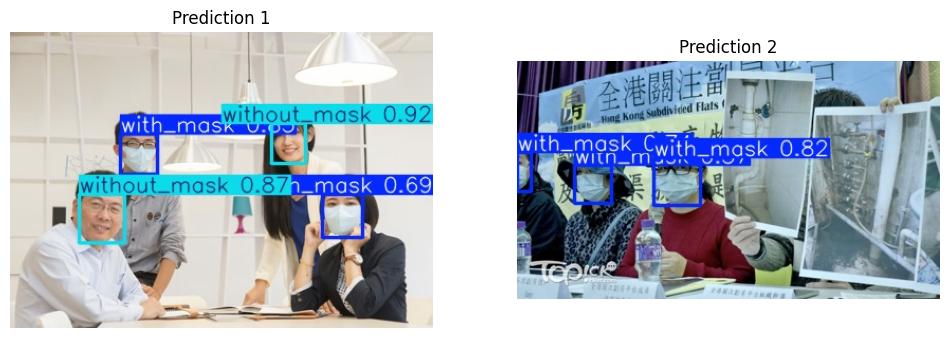

In [14]:
import matplotlib.pyplot as plt
import cv2
import os

# List files in prediction folder (optional, for confirmation)
print("Files in prediction folder:", os.listdir('/content/runs/detect/predict'))

# Paths to YOLO prediction images
image1_path = '/content/runs/detect/predict/maksssksksss96.jpg'
image2_path = '/content/runs/detect/predict3/maksssksksss77.jpg'

# Load images
img1 = cv2.imread(image1_path)
img2 = cv2.imread(image2_path)

# Check if both images loaded successfully
if img1 is None or img2 is None:
    print("Error: One or both images could not be loaded. Check paths.")
else:
    # Convert to RGB for correct display
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Display side by side
    plt.figure(figsize=(12, 6))  # Width, Height
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
    plt.imshow(img1)
    plt.title('Prediction 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)  # Position 2
    plt.imshow(img2)
    plt.title('Prediction 2')
    plt.axis('off')

    plt.show()


## Output Files
- Trained YOLOv8 model: `runs/detect/train/weights/best.pt`
- Training logs & results: `runs/detect/train/`
- YOLO-ready dataset: `datasets/`
